In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier 

from sklearn.metrics import plot_confusion_matrix, auc, roc_auc_score, roc_curve, f1_score, accuracy_score

from train_test_comparison import check_dfs
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', 50)

In [2]:
# Импортируем данные

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
RANDOM_SEED = 42

In [4]:
display(train.head(5))
test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [5]:
# Информация о наших данных

print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
print(f'{train.columns}\n\n{test.columns}')

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту


# Сравнение датасетов перед слиянием

In [7]:
# Посмотрим на наличие дупликатов в данных

train.duplicated().sum()

0

In [8]:
# Наглядно сравним два наших датасета между собой

check_dfs(train, test)

,train_feats,train_types,train_sample,nunique_train,< - >,test_feats,test_types,test_sample,nunique_test
0,client_id,int64,26995,73799,| - |,client_id,int64,49000,36349.0
1,app_date,object,03FEB2014,120,| - |,app_date,object,25FEB2014,120.0
2,education,object,UGR,5,| - |,education,object,GRD,5.0
3,sex,object,M,2,| - |,sex,object,F,2.0
4,age,int64,50,52,| - |,age,int64,32,51.0
5,car,object,Y,2,| - |,car,object,Y,2.0
6,car_type,object,N,2,| - |,car_type,object,Y,2.0
7,decline_app_cnt,int64,2,21,| - |,decline_app_cnt,int64,0,19.0
8,good_work,int64,0,2,| - |,good_work,int64,1,2.0
9,score_bki,float64,-1.7001,69096,| - |,score_bki,float64,-1.92933,34287.0


Резюме:
1. Не совпали типы в:= 1 столбцах

2. Уникальные значения различаются в:= 6 столбцах [0, 4, 7, 9, 10, 14]


,train_feats,не совпадают типы,test_feats
index,,,
18,default,int64 != nan,NaN


Как мы видим, тип данных не совпал лишь в тагрет признаке (что очевидно). В остальном выглядит все довольно неплохо. Несоответствие уникальных значений будем смотреть уже при пристальном рассмотрении каждого признака отдельно.

In [9]:
# Пропуски в данных

print(f'train data:\n{train.isna().sum()}\n\ntest data:\n{test.isna().sum()}')

train data:
client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

test data:
client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64


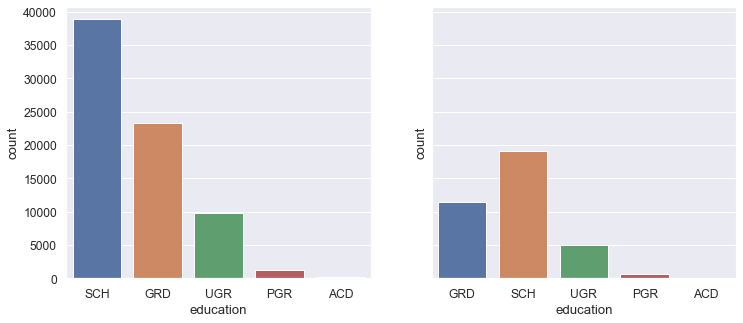

In [10]:
sns.set()
sns.set_context("notebook", font_scale = 1.1)

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 5)

_ = sns.countplot(train['education'], ax=ax[0])
_ = sns.countplot(test['education'], ax=ax[1])

В обоих случаях уровень образования SCH значительно превышает остальные по количеству.

In [11]:
# Заполним пропуски значением, которое встречается чаще всего

c_1 = Counter(train['education'])
c_2 = Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

In [12]:
# Еще раз проверим пропуски в данных

print(f'train data:\n{train.isna().sum().sum()}\n\ntest data:\n{test.isna().sum().sum()}')

train data:
0

test data:
0


# Слияние и предварительный анализ датасета

In [13]:
# Создадим признак для разделения датасетов

train['train'] = 1 # Здесь у нас тренировочный датасет
test['train'] = 0  # А тут тестовый

# Объединим наши датасеты

df = train.append(test, sort=False).reset_index(drop=True)

In [14]:
# Проверим после слияния 

df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
37751,84141,01APR2014,SCH,M,52,Y,N,0,1,-2.635583,1,40,2,3,15000,1,4,N,0.0,1
5922,61641,11MAR2014,SCH,M,35,Y,Y,0,0,-2.468437,2,50,1,1,45000,1,4,N,0.0,1
78518,41598,18FEB2014,SCH,F,41,N,N,5,0,-1.030459,7,40,2,3,25000,4,1,N,NaN,0
22538,106491,25APR2014,SCH,F,61,N,N,1,0,-2.036645,1,40,2,3,14000,1,2,N,0.0,1
68435,10656,18JAN2014,SCH,F,54,N,N,0,0,-1.894216,0,70,1,3,70000,1,3,Y,0.0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [16]:
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

# EDA And Feature Engineering

In [17]:
# Составим функцию для предварительного анализа каждого признака

def col_info(col):
    print('{}\n'.format(col.describe()))
    print('Распределение:\n{}\n'.format(col.value_counts()))

In [18]:
# Создадим списки с типами наших значений, куда будем отправлять каждый из признаков после анализа

cat_cols = []  # Категориальные признаки
num_cols = []  # Числовые признаки
bin_cols = []  # Бинарные признаки
ordinal_cat_cols = [] # Категориальные порядковые признаки

## 1. App_date

In [19]:
col_info(df.app_date)

count        110148
unique          120
top       18MAR2014
freq           1491
Name: app_date, dtype: object

Распределение:
18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64



In [20]:
# Сконветируем формат даты к удобному для работы

df['app_date'] = pd.to_datetime(df.app_date)
print(df.app_date)

0        2014-02-01
1        2014-03-12
2        2014-02-01
3        2014-01-23
4        2014-04-18
            ...    
110143   2014-03-31
110144   2014-04-25
110145   2014-03-30
110146   2014-01-07
110147   2014-03-17
Name: app_date, Length: 110148, dtype: datetime64[ns]


In [21]:
# Проверим нашей функцией

col_info(df.app_date)

count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

Распределение:
2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64



In [22]:
print(f'Первая дата подачи заявки: {df.app_date.min()}')
print(f'Последняя дата подачи заявки: {df.app_date.max()}')

Первая дата подачи заявки: 2014-01-01 00:00:00
Последняя дата подачи заявки: 2014-04-30 00:00:00


Распределение дат подачи в нашем случае с 1 января до 30 апреля 2014 года. Обозначим первую дату как стартовую

In [23]:
start_date = df.app_date.min()

In [24]:
# Исследуем значения признака

print(f'Месяц подачи заявок в train: {df[df.train==1].app_date.dt.month.unique()}')
print(f'Месяц подачи заявок в test: {df[df.train==0].app_date.dt.month.unique()}')
print(f'День подачи заявок в train: {df[df.train==1].app_date.dt.day.unique()}')
print(f'День подачи заявок в test: {df[df.train==0].app_date.dt.day.unique()}')

Месяц подачи заявок в train: [2 3 1 4]
Месяц подачи заявок в test: [3 1 2 4]
День подачи заявок в train: [ 1 12 23 18  4 17 14 10  3  8 19 22 30 11  2  6 24 15 28  9 31 26 13 25
 21 20 16 27  7  5 29]
День подачи заявок в test: [22 24 23  3  4 17  2 28 25 15 13 12  1 20 27 18 16  7  8 21 19  5  6 29
 31 11 14 10 26 30  9]


<AxesSubplot:xlabel='app_date', ylabel='default'>

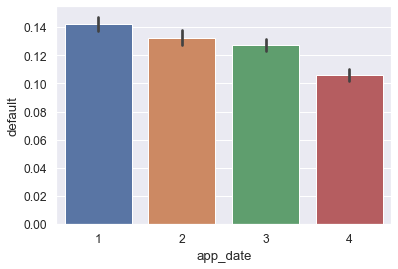

In [25]:
# Проверим зависимость дефолта от месяца подачи заявки

sns.barplot(data=df[df['train']==1], x=df.loc[df['train']==1,'app_date'].dt.month, y='default')

Как видно из графика, среднее количество дефолтов отрицательно коррелирует с месяцем подачи заявки

In [26]:
# Создадим на основании полученных данных новые признаки

## Количество дней с первой даты подачи заявок
df['days_from_start'] = (df.app_date - start_date).dt.days 

## При помощи target encoding создадим признак являющийся средним количеством дефолтов в месяце подачи заявки
encoded = df.groupby(df.loc[df['train']==1,'app_date'].dt.month).mean().default
encoding_dict = dict(encoded)

df['month_default_mean'] = df['app_date'].dt.month.apply(lambda x: encoding_dict[x])

Идея для фичи: бинарный признак принадлежности дня подачи заявки к одной из двух групп дней.

Обоснование признака:

- срок выплаты заработной платы в РФ за первую половину месяца - не позднее 30 (31) числа текущего месяца
- за вторую половину месяца - не позднее 15 числа след. месяца

Вероятность того, что человек внесет платеж после получения заработной платы очевидно выше, чем до, следовательно, имеет смысл разбить дни на два интервала. Но встает вопрос, какие же интервалы брать. К сожалению точную статистику по рф я найти не смог но исходя из личного опыта могу предположить, что наиболее частыми датами для выплат являются 10 и 25 числа месяца. Разобьем дни на две группы. В первую будут входить даты с 10 по 15 и с 25 по 31 числа включительно (будем считать их датами получения заработной платы и интервалами после), а во вторую все остальные дни.

In [27]:
# Создадим наш признак

#df['salary_days'] = df['app_date'].dt.day.apply(lambda x: 1 if x in np.arange(10, 16) or x in np.arange(25, 32) else 0)
df['salary_days'] = df['app_date'].dt.day.apply(lambda x: 1 if x in np.arange(9, 22) else 0)

По итогу первый варииант провалился в тесте значимости признаков, второй вариант разбивки дней был взят из данной статьи https://habr.com/ru/post/454574/

In [28]:
# Добавим признаки в списки
num_cols.append('days_from_start')
num_cols.append('month_default_mean')
bin_cols.append('salary_days')

## 2. Education

In [29]:
col_info(df.education)

count     110148
unique         5
top          SCH
freq       58476
Name: education, dtype: object

Распределение:
SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64



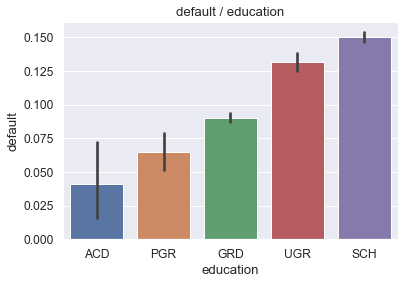

In [30]:
order = df[df.train == 1].groupby('education').default.mean().sort_values().index

g = sns.barplot(x = 'education', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / education')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

По графику видно, что вероятность дефолта тем нижу чем выше уровень образования (отрицательно коррелирует с уровнем образования).

По сути своей признак категориальный, но так же присутствует некий порядок (SCH<GRD<UGR<PGR<ACD по важности т.к. очевидно, что в большинстве случаев человек с научной степенью ACD зарабатывает больше, чем тот кто просто окончил школу SCH). Попробуем использовать его как категориальный порядковый

In [31]:
# Добавим признак в списки

ordinal_cat_cols.append('education')

## 3. Sex

In [32]:
col_info(df.sex)

count     110148
unique         2
top            F
freq       61836
Name: sex, dtype: object

Распределение:
F    61836
M    48312
Name: sex, dtype: int64



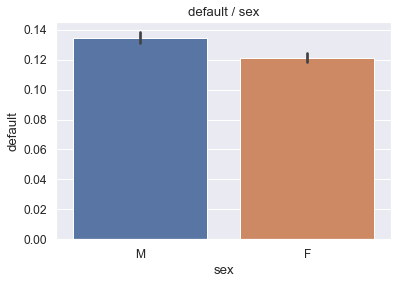

In [33]:
g = sns.barplot(x = 'sex', y = 'default', data = df[df.train == 1])
g.set_title('default / sex')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Из графика видно, что вероятность дефолта у мужчин выше, чем у женщин

Добавим признак к бинарным и позже преобразуем

In [34]:
# Добавим признак в списки

bin_cols.append('sex')

## 4. Age

In [35]:
col_info(df.age)

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

Распределение:
31    4084
28    4035
30    4035
27    3964
29    3940
26    3780
32    3773
34    3548
33    3499
35    3386
25    3292
36    3228
37    3185
39    3095
38    3070
40    2950
42    2857
41    2804
24    2780
43    2672
44    2536
23    2295
45    2235
50    2104
46    2102
48    2084
47    2074
52    2065
51    2015
53    1980
49    1964
54    1911
55    1837
56    1641
57    1578
22    1415
58    1373
59    1340
21    1262
60    1236
61     975
62     885
63     720
64     663
65     618
66     442
67     382
68     261
69     110
70      60
71       6
72       2
Name: age, dtype: int64



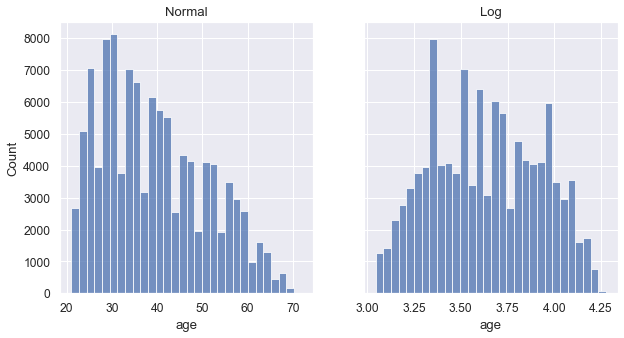

In [36]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.age, ax=ax[0], bins=30)
_ = sns.histplot(np.log(df.age), ax=ax[1], bins=30)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

Распределение признака выглядит как логнормальное, посмотрим зависимость дефолта от возраста клиента

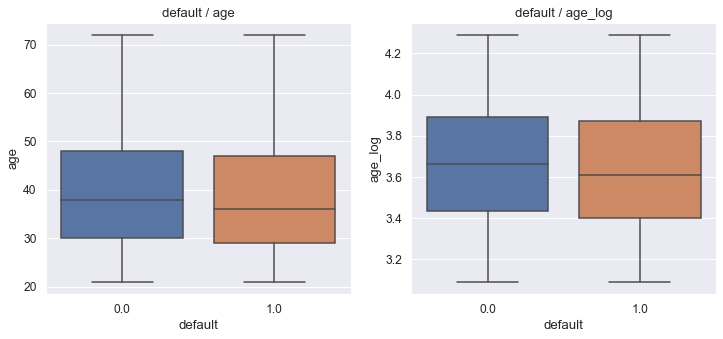

In [37]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].age, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].age + 1), ax=ax[1])

a.set_title('default / age')
g.set_title('default / age_log')
a.set_ylabel('age')
g.set_ylabel('age_log')

plt.show()

Из графика видно, что у дефолтных клиентов медианный возраст чуть меньше, чем у недефолтных

Создадим бинарный признак принадлежности клиента к пенсионному возрасту (вероятность дефолта в таком случае намного выше). Пенсионный возраст в 2014 году 60 лет для мужчин и 55 лет для женщин (не будем учитывать особые условия выхода на пенсию для различных профессий)

In [38]:
df['retirement_age'] = df.apply(lambda x: 1 if (x.sex == 'M' and x.age >= 60) or (x.sex == 'F' and x.age >= 55) else 0, axis=1)

In [39]:
df['age'] = np.log(df.age)

In [40]:
# Добавим признаки в списки

num_cols.append('age')
bin_cols.append('retirement_age')

## 5. Car

In [41]:
col_info(df.car)

count     110148
unique         2
top            N
freq       74290
Name: car, dtype: object

Распределение:
N    74290
Y    35858
Name: car, dtype: int64



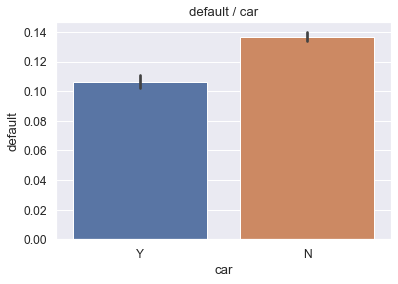

In [42]:
g = sns.barplot(x = 'car', y = 'default', data = df[df.train == 1])
g.set_title('default / car')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Клиенты без авто чаще оказываются дефолтными, чем при наличии

In [43]:
# Добавим признаки в списки

bin_cols.append('car')

## 6. Car_type

In [44]:
col_info(df.car_type)

count     110148
unique         2
top            N
freq       89140
Name: car_type, dtype: object

Распределение:
N    89140
Y    21008
Name: car_type, dtype: int64



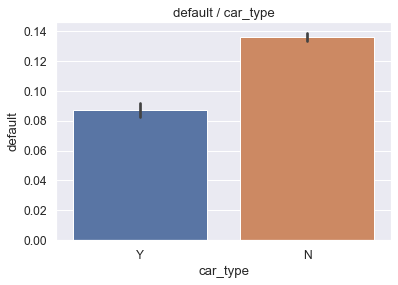

In [45]:
g = sns.barplot(x = 'car_type', y = 'default', data = df[df.train == 1])
g.set_title('default / car_type')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Клиенты с иномарками реже дефолные, чем обладатели отечественных авто

In [46]:
# Добавим признаки в списки

bin_cols.append('car_type')

## 7. decline_app_cnt

In [47]:
col_info(df.decline_app_cnt)

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

Распределение:
0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64



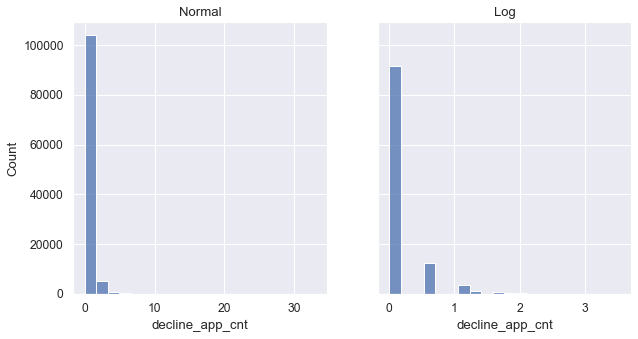

In [48]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.decline_app_cnt, ax=ax[0], bins=20)
_ = sns.histplot(np.log(df.decline_app_cnt+1), ax=ax[1], bins=20)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

По графику похоже на логнормальное распределение

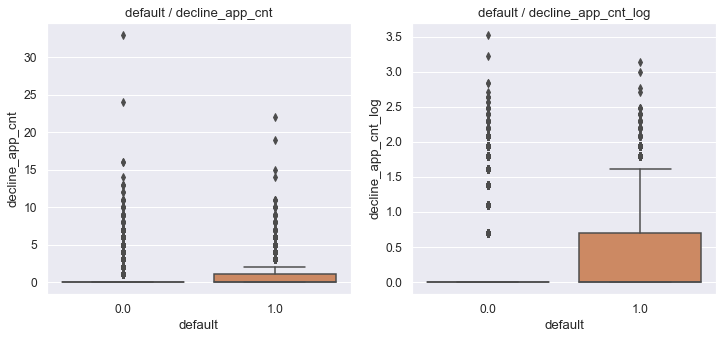

In [49]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].decline_app_cnt, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].decline_app_cnt + 1), ax=ax[1])

a.set_title('default / decline_app_cnt')
g.set_title('default / decline_app_cnt_log')
a.set_ylabel('decline_app_cnt')
g.set_ylabel('decline_app_cnt_log')

plt.show()

В среднем конечно у дефолтных клиентов отказных заявок больше, но в данных много выбросов. Удалять их все не будет смысла, поэтому попробуем лишь ограничить максимальный порог наивысшим значением из теста

In [50]:
test_decline_app_cnt_max = df[df.train == 0].decline_app_cnt.max()

print(test_decline_app_cnt_max)

30


In [51]:
# Оставим значения по границе максимума

df = df[df.decline_app_cnt <= test_decline_app_cnt_max]

col_info(df.decline_app_cnt)

count    110147.000000
mean          0.272908
std           0.792995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: decline_app_cnt, dtype: float64

Распределение:
0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
24        1
15        1
19        1
20        1
21        1
22        1
30        1
Name: decline_app_cnt, dtype: int64



По итогу удалилось всего одно значение)))))))))))

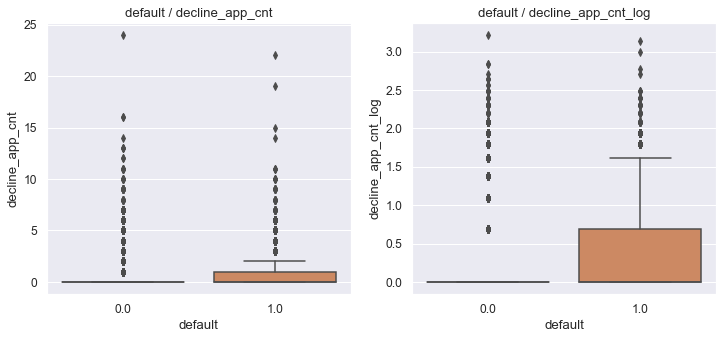

In [52]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].decline_app_cnt, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].decline_app_cnt + 1), ax=ax[1])

a.set_title('default / decline_app_cnt')
g.set_title('default / decline_app_cnt_log')
a.set_ylabel('decline_app_cnt')
g.set_ylabel('decline_app_cnt_log')

plt.show()

In [53]:
df['decline_app_cnt'] = np.log(df.decline_app_cnt + 1)

In [54]:
# Добавим признак в списки

num_cols.append('decline_app_cnt')

## 8. good_work

In [55]:
col_info(df.good_work)

count    110147.000000
mean          0.165515
std           0.371647
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: good_work, dtype: float64

Распределение:
0    91916
1    18231
Name: good_work, dtype: int64



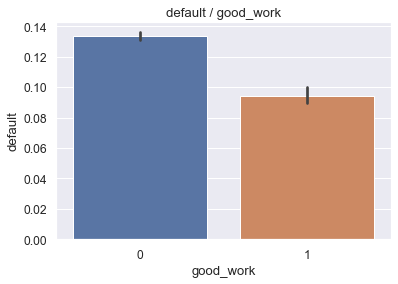

In [56]:
g = sns.barplot(x = 'good_work', y = 'default', data = df[df.train == 1])
g.set_title('default / good_work')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Клиент с "хорошей" работой чаще является недефолтным

In [57]:
# Добавим признак в списки

bin_cols.append('good_work')

## 9. bki_request_cnt

In [58]:
col_info(df.bki_request_cnt)

count    110147.000000
mean          2.005002
std           2.266936
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

Распределение:
0     28908
1     27295
2     20480
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64



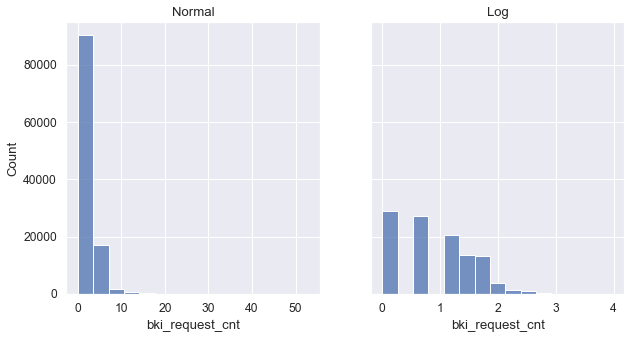

In [59]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.bki_request_cnt, ax=ax[0], bins=15)
_ = sns.histplot(np.log(df.bki_request_cnt+1), ax=ax[1], bins=15)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

Распределение по графику логнормальное

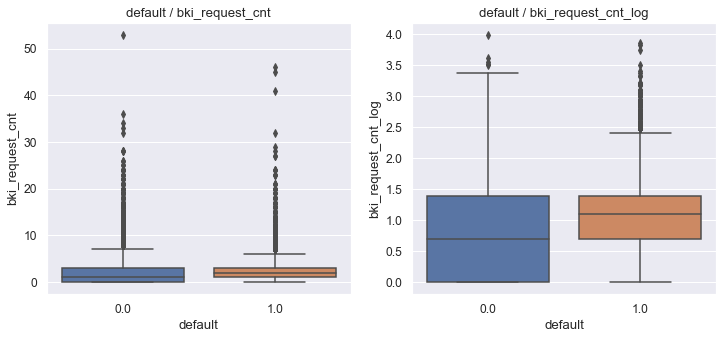

In [60]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].bki_request_cnt, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].bki_request_cnt + 1), ax=ax[1])

a.set_title('default / bki_request_cnt')
g.set_title('default / bki_request_cnt_log')
a.set_ylabel('bki_request_cnt')
g.set_ylabel('bki_request_cnt_log')

plt.show()

В среднем у дефолтных клиентов заявок в бки больше. Выбросы в признаке так же есть. Ограничим их по максимальному значению теста

In [61]:
test_bki_request_cnt_max = df[df.train == 0].bki_request_cnt.max()

print(test_bki_request_cnt_max)

47


In [62]:
# Оставим значения по границе максимума

df = df[df.bki_request_cnt <= test_bki_request_cnt_max]

col_info(df.bki_request_cnt)

count    110146.000000
mean          2.004539
std           2.261733
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          47.000000
Name: bki_request_cnt, dtype: float64

Распределение:
0     28908
1     27295
2     20480
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
28        5
25        5
27        5
26        4
32        4
29        3
40        2
33        2
45        1
41        1
46        1
36        1
34        1
47        1
Name: bki_request_cnt, dtype: int64



Точно так же удалилось одно значение как и с отклоненными заявками

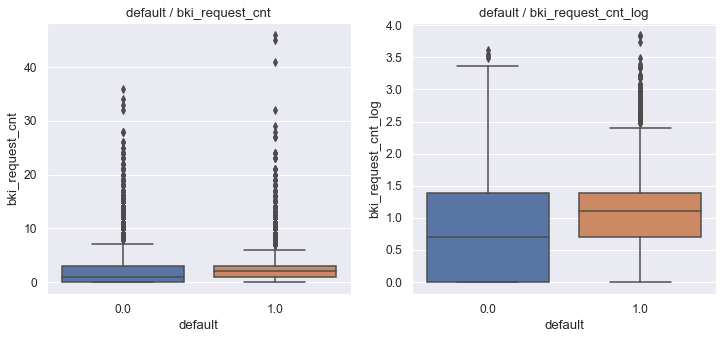

In [63]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].bki_request_cnt, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].bki_request_cnt + 1), ax=ax[1])

a.set_title('default / bki_request_cnt')
g.set_title('default / bki_request_cnt_log')
a.set_ylabel('bki_request_cnt')
g.set_ylabel('bki_request_cnt_log')

plt.show()

In [64]:
df['bki_request_cnt'] = np.log(df.bki_request_cnt + 1)

In [65]:
# Добавим признак в списки

num_cols.append('bki_request_cnt')

## 10. home_address

In [66]:
col_info(df.home_address)

count    110146.000000
mean          1.574946
std           0.527563
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: home_address, dtype: float64

Распределение:
2    59590
1    48687
3     1869
Name: home_address, dtype: int64



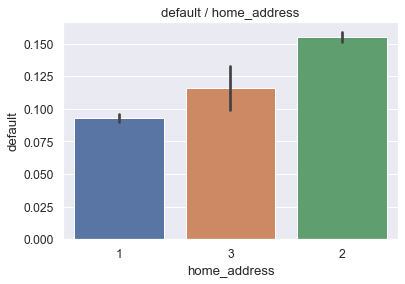

In [67]:
order = df[df.train == 1].groupby('home_address').default.mean().sort_values().index

g = sns.barplot(x = 'home_address', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / home_address')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Зависимость дефолтности от адреса присутсвует

In [68]:
# Добавим признаки в списки

cat_cols.append('home_address')

## 11. work_address

In [69]:
col_info(df.work_address)

count    110146.000000
mean          2.497876
std           0.687640
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: work_address, dtype: float64

Распределение:
3    67112
2    30761
1    12273
Name: work_address, dtype: int64



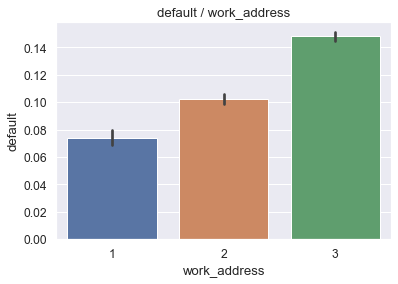

In [70]:
order = df[df.train == 1].groupby('work_address').default.mean().sort_values().index

g = sns.barplot(x = 'work_address', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / work_address')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Зависимость дефолтности от рабочего адреса присутсвует

In [71]:
# Добавим признаки в списки

cat_cols.append('work_address')

## 12. income

In [72]:
col_info(df.income)

count     110146.000000
mean       41012.621530
std        45400.045551
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

Распределение:
30000     10437
25000      9090
20000      8173
40000      7383
50000      6742
          ...  
27478         1
27350         1
20412         1
23120         1
426000        1
Name: income, Length: 1207, dtype: int64



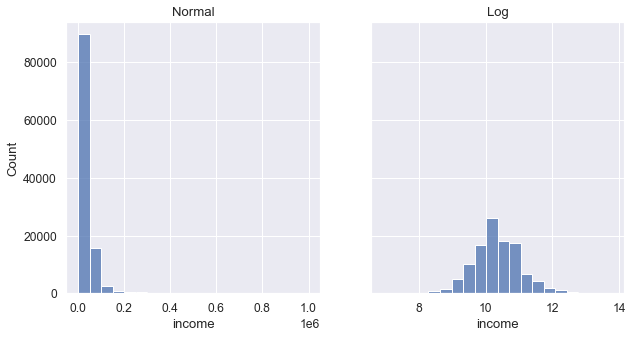

In [73]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.income, ax=ax[0], bins=20)
_ = sns.histplot(np.log(df.income), ax=ax[1], bins=20)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

Распределение на графике логнормальное

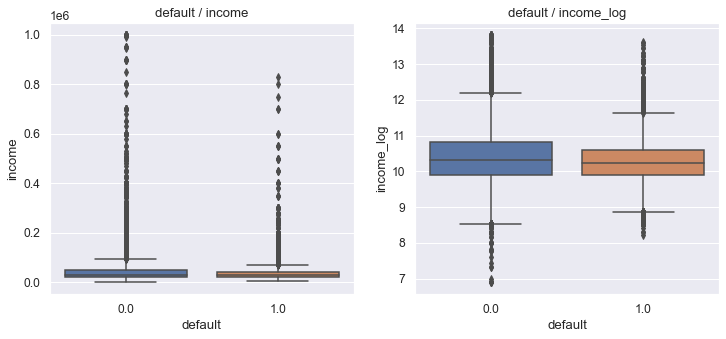

In [74]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].income, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].income), ax=ax[1])

a.set_title('default / income')
g.set_title('default / income_log')
a.set_ylabel('income')
g.set_ylabel('income_log')

plt.show()

Доход у недефолтных клиентов выше. В признаке много выбросов, будем чистить

In [75]:
# Функция определяет межквартильный интервал и возвращает 1.5 межквартильных расстояния с обеих
# сторон от этого интервала. С её помощью избавимся от выбросов.

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

Для удобства разделим датасет, удалим выбросы из трейна и снова соединим

In [76]:
# Разделяем

train = df[df.train==1]
test = df[df.train==0]

In [77]:
# Удаляем выбросы

bounds = outliers_iqr(train.income)
train = train.loc[train.income.between(bounds[0], bounds[1])]

In [78]:
# Соединяем в один

df = train.append(test, sort=False).reset_index(drop=True)

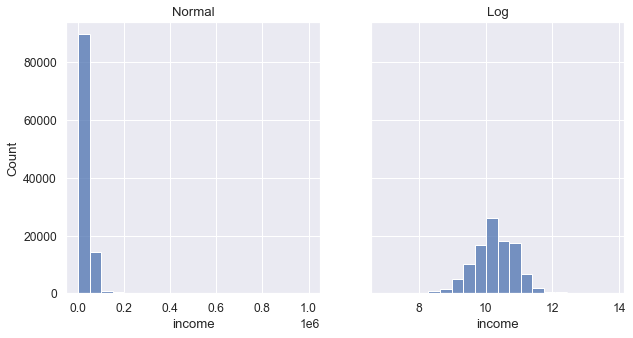

In [79]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.income, ax=ax[0], bins=20)
_ = sns.histplot(np.log(df.income), ax=ax[1], bins=20)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

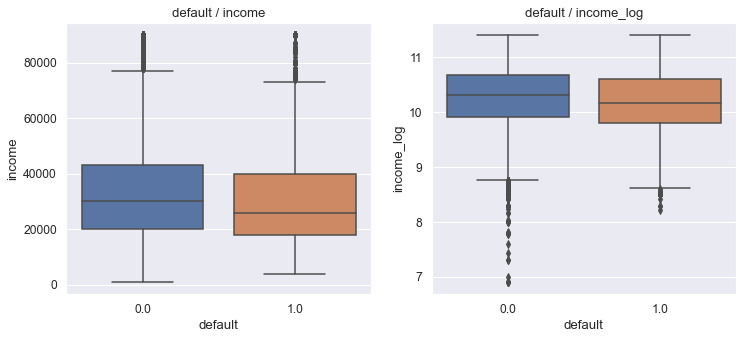

In [80]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].income, ax=ax[0])
g = sns.boxplot(x=df[df.train==1].default, y=np.log(df[df.train==1].income), ax=ax[1])

a.set_title('default / income')
g.set_title('default / income_log')
a.set_ylabel('income')
g.set_ylabel('income_log')

plt.show()

Приемлемый результат

In [81]:
df['income'] = np.log(df.income)

In [82]:
# Добавим признак в списки

num_cols.append('income')

## 13. foreign_passport

In [83]:
col_info(df.foreign_passport)

count     105451
unique         2
top            N
freq       90990
Name: foreign_passport, dtype: object

Распределение:
N    90990
Y    14461
Name: foreign_passport, dtype: int64



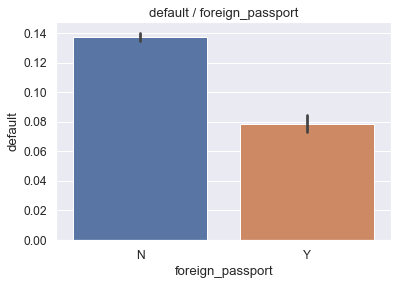

In [84]:
g = sns.barplot(x = 'foreign_passport', y = 'default', data = df[df.train == 1])
g.set_title('default / foreign_passport')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Клиенты без загранпаспорта чаще оказываются дефолтными

In [85]:
# Добавим признаки в списки

bin_cols.append('foreign_passport')

## 14. sna

In [86]:
col_info(df.sna)

count    105451.000000
mean          1.745104
std           1.129952
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64

Распределение:
1    67079
4    17105
2    15277
3     5990
Name: sna, dtype: int64



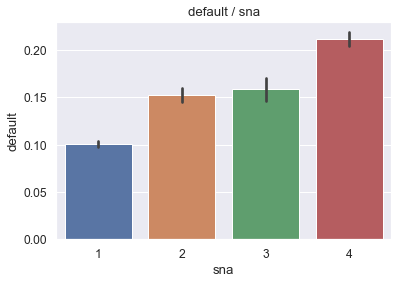

In [87]:
order = df[df.train == 1].groupby('sna').default.mean().sort_values().index

g = sns.barplot(x = 'sna', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / sna')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Дефолтность линейно коррелирует с признаком. Можно сделать вывод, что чем больше число, тем больше связей у заемщика с клиентами банка. Данный признак можно использовать как категориальный порядковый

In [88]:
# Добавим признаки в списки

ordinal_cat_cols.append('sna')

## 15. first_time

In [89]:
col_info(df.first_time)

count    105451.000000
mean          2.750472
std           1.013803
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: first_time, dtype: float64

Распределение:
3    44498
4    26319
1    17998
2    16636
Name: first_time, dtype: int64



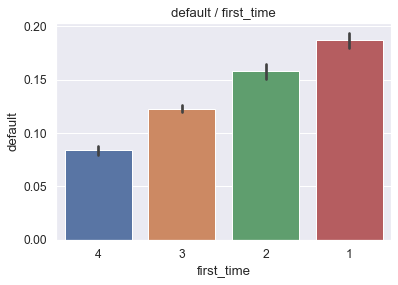

In [90]:
order = df[df.train == 1].groupby('first_time').default.mean().sort_values().index

g = sns.barplot(x = 'first_time', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / first_time')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Дефолтность обратно скоррелированна с давностью информации о клиенте. Из-за такой зависимости можно предположить, что чем ниже число, тем более свежая информация о заемщике у банка, следовательно, можно использовать данный признак как категориальный порядковый

In [91]:
# Добавим признаки в списки

ordinal_cat_cols.append('first_time')

## 16. score_bki

In [92]:
col_info(df.score_bki)

count    105451.000000
mean         -1.902317
std           0.497409
min          -3.624586
25%          -2.256464
50%          -1.920823
75%          -1.566645
max           0.199773
Name: score_bki, dtype: float64

Распределение:
-1.775263    493
-2.104211    446
-2.225004    415
-2.169664    369
-2.024100    270
            ... 
-1.616856      1
-1.130138      1
-2.242299      1
-2.393507      1
-2.729079      1
Name: score_bki, Length: 98220, dtype: int64



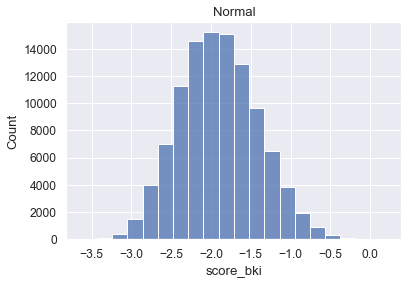

In [93]:
g = sns.histplot(df.score_bki, bins=20)

g.set_title('Normal')

plt.show()

Распределение - нормальное

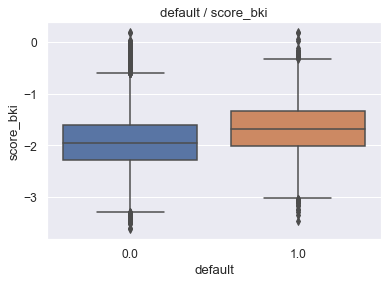

In [94]:
a = sns.boxplot(x=df[df.train==1].default, y=df[df.train==1].score_bki)

a.set_title('default / score_bki')
a.set_ylabel('score_bki')

plt.show()

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

In [95]:
# Добавим признаки в списки

num_cols.append('score_bki')

## 17. region_rating

In [96]:
col_info(df.region_rating)

count    105451.000000
mean         56.433035
std          12.920783
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

Распределение:
50    39814
60    23232
40    17514
80    15568
70     8592
30      424
20      307
Name: region_rating, dtype: int64



Значений не так много, посмотрим график распределения, а так же barplot

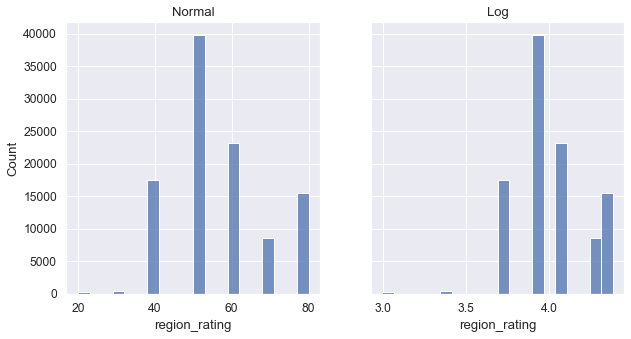

In [97]:
# Распределение на гистограмме

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)

_ = sns.histplot(df.region_rating, ax=ax[0], bins=20)
_ = sns.histplot(np.log(df.region_rating), ax=ax[1], bins=20)

ax[0].set_title('Normal')
ax[1].set_title('Log')

plt.show()

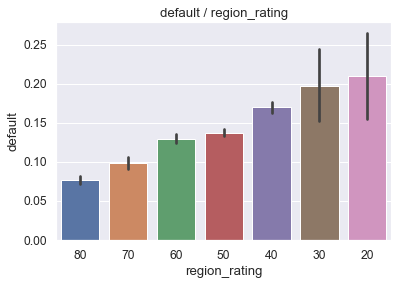

In [98]:
# Барплот

order = df[df.train == 1].groupby('region_rating').default.mean().sort_values().index

g = sns.barplot(x = 'region_rating', y = 'default', data = df[df.train == 1], order=order)
g.set_title('default / region_rating')
g.set_ylabel('default')
g.set_xticklabels(g.get_xticklabels())

plt.show()

График распределения не дал нам никакой информации, зато на барплоте мы увидили, как дефолтность обратно скоррелирована с рейтингом региона (чем выше рейтинг, тем ниже вероятность дефолта). Будем использовать данный признак как категориальный порядковый

In [99]:
# Добавим признаки в списки

ordinal_cat_cols.append('region_rating')

## 18. default

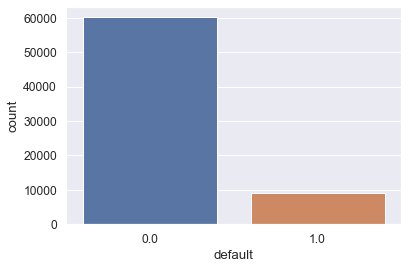

In [100]:
fig.set_size_inches(12, 5)

_ = sns.countplot(train['default'])

Как видно из графика, классы мягко говоря не сбалансированны займемся этим чуть позже

## Создание доп. признаков при помощи target encoding

In [101]:
def calc_smooth_mean(df, df_1, by, target, m):
    # Compute the global mean
    mean = df_1[target].mean()

    # Compute the number of values and the mean of each group
    agg = df_1.groupby(by)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [102]:
for col in (ordinal_cat_cols+cat_cols):
    df[col] = calc_smooth_mean(df, df[df.train==1], col, 'default', 300)

In [103]:
for col in (ordinal_cat_cols+cat_cols):
    num_cols.append(col)

# Data Preprocessing

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [104]:
le = LabelEncoder()

for column in bin_cols:
    df[column] = le.fit_transform(df[column])
    
# убедимся в преобразовании    
display(df.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,days_from_start,month_default_mean,salary_days,retirement_age
0,25905,2014-02-01,0.150548,1,4.127134,1,1,0.000000,0,-2.008753,0.693147,0.137153,0.094876,0.104451,9.798127,0.209539,0.185438,0,0.0,1,31,0.132627,0,1
1,63161,2014-03-12,0.150548,0,4.077537,0,0,0.000000,0,-1.532276,1.386294,0.137153,0.159106,0.152073,9.852194,0.209539,0.185438,0,0.0,1,70,0.127538,1,1
2,25887,2014-02-01,0.150548,1,3.218876,1,0,1.098612,0,-1.408142,0.693147,0.078779,0.094876,0.104451,10.308953,0.100910,0.084489,1,0.0,1,31,0.132627,0,0
3,16222,2014-01-23,0.150548,0,3.970292,0,0,0.000000,0,-2.057471,1.098612,0.137153,0.159106,0.152073,9.210340,0.100910,0.122890,0,0.0,1,22,0.142342,0,0
4,101655,2014-04-18,0.093280,1,3.871201,0,0,0.000000,1,-1.244723,0.693147,0.129738,0.159106,0.152073,10.308953,0.100910,0.084489,1,0.0,1,107,0.105921,1,0


# Матрица корреляции и значимость переменных

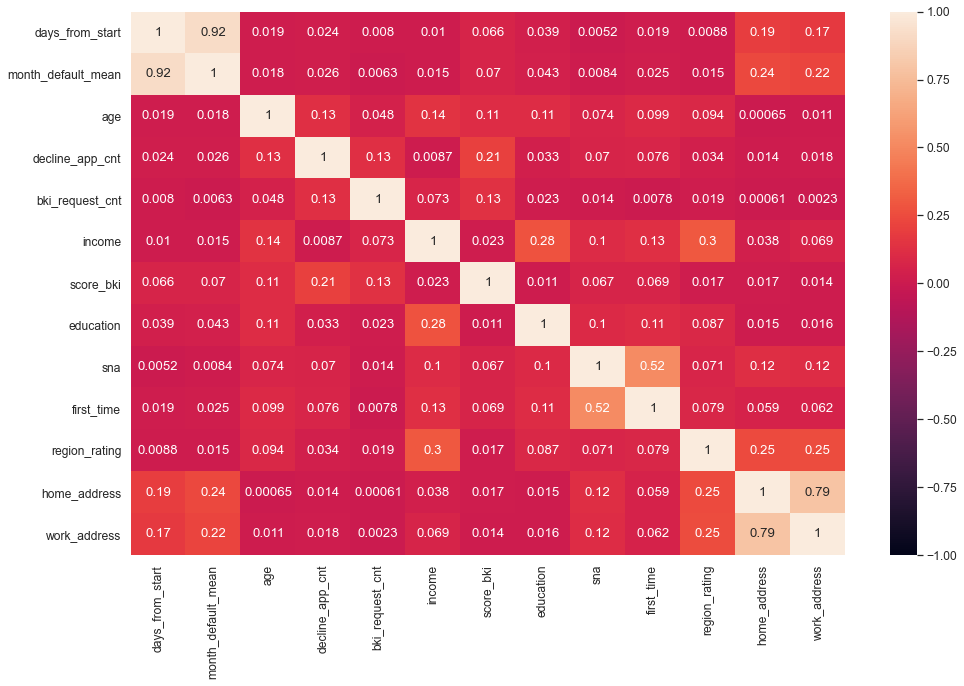

In [105]:
# Построим матрицу корреляции непрерывных переменных

plt.figure(figsize=(16,10))
sns.heatmap(df[df.train==1][num_cols].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

Высокая корреляция наблюдается лишь между признаками days_from_start и month_default_mean. Пока что не будем удалять их и посмотрим на работу модели

Text(0.5, 0, 'F-value')

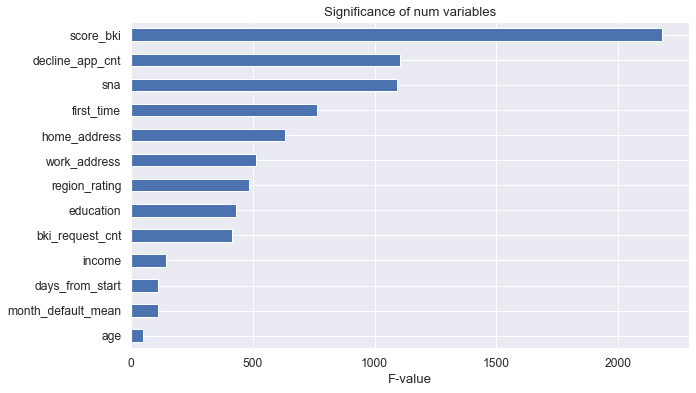

In [106]:
# Построим график значимости непрерыных переменных по ANOVA test
plt.figure(figsize=(10, 6))

imp_num = pd.Series(f_classif(df[df.train == 1][num_cols], df[df.train == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

Как видно из графика, скоринговый балл оказывает наибольшую значимость, а возраст наименьшую

Text(0.5, 1.0, 'Significance of bin variables')

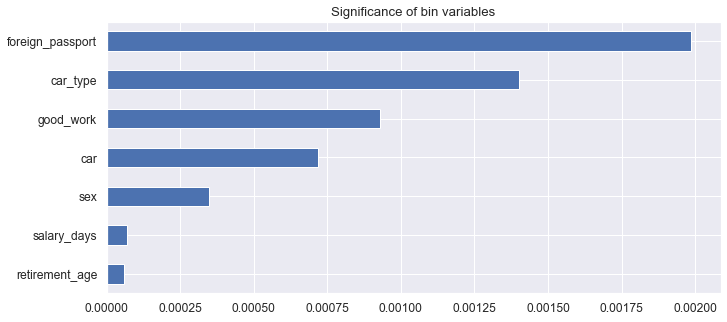

In [107]:
# Значимость бинарных признаков

plt.figure(figsize=(11, 5))

imp_bin = pd.Series(mutual_info_classif(df[df.train == 1][bin_cols], df[df.train == 1]['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Как мы видим из графика, наибольший импакт вносит флаг наличия загранпаспорта, наименьший - пенсионный возраст

# Подготовка данных к машинному обучению

In [108]:
# Создадим дополнительно полиномиальные признаки

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

poly_feats = poly.fit_transform(df[num_cols].values)

In [109]:
poly.get_feature_names(df[num_cols].columns)

['days_from_start',
 'month_default_mean',
 'age',
 'decline_app_cnt',
 'bki_request_cnt',
 'income',
 'score_bki',
 'education',
 'sna',
 'first_time',
 'region_rating',
 'home_address',
 'work_address',
 'days_from_start month_default_mean',
 'days_from_start age',
 'days_from_start decline_app_cnt',
 'days_from_start bki_request_cnt',
 'days_from_start income',
 'days_from_start score_bki',
 'days_from_start education',
 'days_from_start sna',
 'days_from_start first_time',
 'days_from_start region_rating',
 'days_from_start home_address',
 'days_from_start work_address',
 'month_default_mean age',
 'month_default_mean decline_app_cnt',
 'month_default_mean bki_request_cnt',
 'month_default_mean income',
 'month_default_mean score_bki',
 'month_default_mean education',
 'month_default_mean sna',
 'month_default_mean first_time',
 'month_default_mean region_rating',
 'month_default_mean home_address',
 'month_default_mean work_address',
 'age decline_app_cnt',
 'age bki_request_cnt',

In [110]:
poly_df = pd.DataFrame(poly_feats, columns=[poly.get_feature_names(df[num_cols].columns)])

Стандартизируем числовые переменные

In [111]:
scaler = StandardScaler()
poly_df[poly_df.columns] = scaler.fit_transform(poly_df[poly_df.columns])

poly_df

,days_from_start,month_default_mean,age,decline_app_cnt,bki_request_cnt,income,score_bki,education,sna,first_time,region_rating,home_address,work_address,days_from_start month_default_mean,days_from_start age,days_from_start decline_app_cnt,days_from_start bki_request_cnt,days_from_start income,days_from_start score_bki,days_from_start education,days_from_start sna,days_from_start first_time,days_from_start region_rating,days_from_start home_address,days_from_start work_address,...,income first_time,income region_rating,income home_address,income work_address,score_bki education,score_bki sna,score_bki first_time,score_bki region_rating,score_bki home_address,score_bki work_address,education sna,education first_time,education region_rating,education home_address,education work_address,sna first_time,sna region_rating,sna home_address,sna work_address,first_time region_rating,first_time home_address,first_time work_address,region_rating home_address,region_rating work_address,home_address work_address
0,-0.935666,0.433481,1.700420,-0.422047,-0.277132,-0.768949,-0.213983,0.802002,1.967181,1.629842,0.289591,-1.105937,-0.914001,-0.974435,-0.789092,-0.368012,-0.607388,-0.972042,0.764240,-0.721595,-0.276216,-0.449039,-0.804135,-1.014259,-0.988984,...,1.393921,0.074769,-1.197006,-1.030485,-0.685643,-1.787541,-1.413406,-0.352424,0.630885,0.443593,2.194991,1.853170,0.747229,-0.479797,-0.234579,2.309517,1.803010,0.401344,0.709686,1.461250,0.111835,0.407231,-0.715552,-0.494004,-1.082538
1,0.280791,0.040276,1.532278,-0.422047,0.781400,-0.682179,0.743939,0.802002,1.967181,1.629842,0.289591,0.919710,0.775089,0.467743,0.541598,-0.368012,0.840107,0.188458,0.136601,0.595706,1.365274,1.078908,0.380713,0.591961,0.518227,...,1.422466,0.102204,0.680728,0.517169,0.196805,-0.777792,-0.433864,0.431665,0.034612,0.170243,2.194991,1.853170,0.747229,1.312596,1.190239,2.309517,1.803010,2.231343,2.141173,1.461250,1.976771,1.869808,1.050200,0.900420,0.922079
2,-0.935666,0.433481,-1.378735,2.600440,-0.277132,0.050856,0.993501,0.802002,-0.688582,-1.307622,-1.862469,-1.105937,-0.914001,-0.974435,-1.026998,1.011392,-0.607388,-0.924422,1.023998,-0.721595,-0.952635,-1.110204,-1.204974,-1.014259,-0.988984,...,-1.299261,-1.892404,-1.054351,-0.856577,0.426704,1.032301,1.397246,1.622176,1.269431,1.182684,-0.249376,-0.704257,-0.981966,-0.479797,-0.234579,-0.960251,-1.329920,-1.000025,-0.917995,-1.722070,-1.387816,-1.339094,-1.825651,-1.795692,-1.082538
3,-1.216387,1.184100,1.168697,-0.422047,0.342069,-1.712266,-0.311927,0.802002,-0.688582,-0.190214,0.289591,0.919710,0.775089,-1.267864,-1.132100,-0.368012,-0.556006,-1.276110,1.001509,-1.025587,-1.135061,-1.092367,-1.077562,-0.904679,-0.967083,...,-0.556562,-0.223490,0.380133,0.199025,-0.775871,0.369617,-0.086863,-0.432595,-0.901760,-0.770705,-0.249376,0.268586,0.747229,1.312596,1.190239,-0.542505,-0.442227,-0.118730,-0.228617,0.006911,0.418542,0.294455,1.050200,0.900420,0.922079
4,1.434866,-1.629979,0.832761,-0.422047,-0.277132,0.050856,1.322044,-1.409505,-0.688582,-1.307622,0.016222,0.919710,0.775089,1.188165,1.629823,-0.368012,0.401875,1.431633,-0.225100,0.470650,0.587850,0.246411,1.329053,1.745620,1.663154,...,-1.299261,0.051166,0.894638,0.743567,1.606275,1.199082,1.550314,1.015602,0.547292,0.685428,-1.113135,-1.518462,-0.934372,-0.376366,-0.540525,-0.960251,-0.554988,-0.118730,-0.228617,-0.992176,-0.538120,-0.672720,0.813724,0.659683,0.922079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105446,0.873424,0.040276,-0.049644,1.484930,0.781400,-1.061550,0.316322,0.802002,1.967181,1.629842,0.289591,0.919710,0.775089,1.193358,0.845309,2.130611,1.344738,0.688108,-0.533667,1.237468,2.164975,1.823293,0.957947,1.184380,1.106163,...,1.297664,-0.017746,0.570021,0.399999,-0.197120,-1.228545,-0.871132,0.081647,-0.344611,-0.210833,2.194991,1.853170,0.747229,1.312596,1.19

In [112]:
df.drop(columns=num_cols, inplace=True)
df = pd.concat((df, poly_df), axis=1)

In [113]:
num_cols = list(poly_df.columns)

In [114]:
# Разобьем наши данные обратно на train и test

train = df[df.train==1]
test = df[df.train==0]

In [116]:
X = np.hstack((train[bin_cols].values, train[num_cols].values))
y = train['default'].values

## Балансировка классов

Для исправления дисбаланса была выбрана библиотека imbalanced learn и метод случайной наивной избыточной выборки

In [117]:
# Случайная наивная избыточная выборка

X_resampled, y_resampled = RandomOverSampler(random_state=RANDOM_SEED).fit_resample(X, y)

In [118]:
# Проверим распределение классов

print('Количество значений до балансировки:', y.shape)
print('Количество значений после балансировки:', y_resampled.shape)

Количество значений до балансировки: (69102,)
Количество значений после балансировки: (120260,)


# Подбор гиперпараметров

In [119]:
# Разделим наши данный на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=RANDOM_SEED, shuffle = True, stratify=y_resampled)

In [120]:
# Обучим первичную модель

lgr = LogisticRegression(max_iter=800, random_state=RANDOM_SEED)
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=800, random_state=42)

In [121]:
# Сделаем предсказание и посмотрим на метрики

lgr_train_pred = lgr.predict(X_train)
lgr_pred = lgr.predict(X_test)

print(f"Точность модели логистической регрессии на трейне: {accuracy_score(y_train, lgr_train_pred):0.4f}")
print(f"Точность модели логистической регрессии на тесте: {accuracy_score(y_test, lgr_pred):0.4f}")
print()
print(f"F1-score модели логистической регрессии на трейне: {f1_score(y_train, lgr_train_pred):0.4f}")
print(f"F1-score модели логистической регрессии на тесте: {f1_score(y_test, lgr_pred):0.4f}")

Точность модели логистической регрессии на трейне: 0.6760
Точность модели логистической регрессии на тесте: 0.6730

F1-score модели логистической регрессии на трейне: 0.6801
F1-score модели логистической регрессии на тесте: 0.6771


f1-score достаточно высокий, чего не скажешь про accuracy, посмотрим roc_auc и confusion matrix

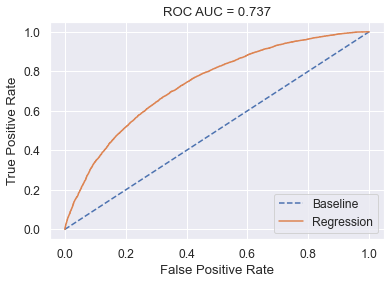

In [122]:
def roc_auc(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]


    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
roc_auc(lgr, X_test, y_test)

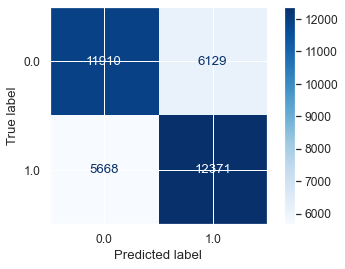

In [123]:
plot_confusion_matrix(lgr, X_test, y_test, cmap='Blues')  
plt.show()

In [128]:
# Зададим сетку параметров

params_grid = [
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
}
]

lgr = LogisticRegression(max_iter=800, random_state=RANDOM_SEED)
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=800, random_state=42)

In [129]:
clf = GridSearchCV(lgr, params_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)

clf.fit(X_train, y_train)
best_model = clf.best_estimator_

# параметры модели
for param_name in sorted(best_model.get_params().keys()):
        print('\t%s: %r' % (param_name, best_model.get_params()[param_name]))
        
# метрики модели
preds = best_model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 800
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'sag'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.6730
F1: 0.6771


In [140]:
lgr = LogisticRegression(max_iter=800, penalty='l2', solver='sag')
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=800, solver='sag')

In [141]:
# Сделаем предсказание и посмотрим на метрики

lgr_train_pred = lgr.predict(X_train)
lgr_pred = lgr.predict(X_test)

print(f"Точность модели логистической регрессии на трейне: {accuracy_score(y_train, lgr_train_pred):0.4f}")
print(f"Точность модели логистической регрессии на тесте: {accuracy_score(y_test, lgr_pred):0.4f}")
print()
print(f"F1-score модели логистической регрессии на трейне: {f1_score(y_train, lgr_train_pred):0.4f}")
print(f"F1-score модели логистической регрессии на тесте: {f1_score(y_test, lgr_pred):0.4f}")

Точность модели логистической регрессии на трейне: 0.6761
Точность модели логистической регрессии на тесте: 0.6730

F1-score модели логистической регрессии на трейне: 0.6802
F1-score модели логистической регрессии на тесте: 0.6771


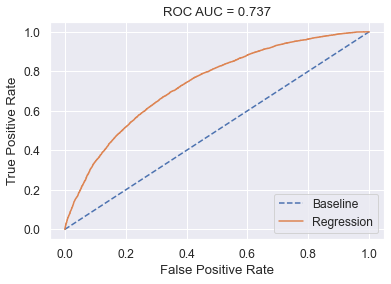

In [142]:
roc_auc(lgr, X_test, y_test)

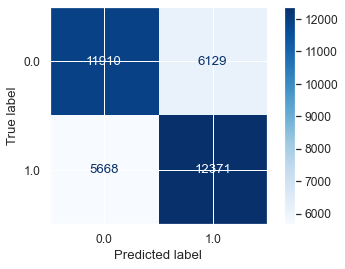

In [143]:
plot_confusion_matrix(lgr, X_test, y_test, cmap='Blues')  
plt.show()

In [151]:
# Подберем параметр С для нашей модели

param = {'C': np.logspace(0, 4, 10)}

lgr = LogisticRegression(max_iter=800, penalty='l2', solver='sag', random_state=RANDOM_SEED)
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=800, random_state=42, solver='sag')

In [152]:
clf = GridSearchCV(lgr, param, scoring='f1', cv=5, verbose=2, n_jobs=-1)
model = clf.fit(X_train, y_train)

print('Лучшее C:', model.best_estimator_.get_params()['C'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшее C: 1.0


## Построенние ансамбля

In [159]:
lgr = LogisticRegression(max_iter=800, penalty='l2', solver='sag', random_state=RANDOM_SEED)
bc = BaggingClassifier(lgr, n_estimators=100, bootstrap=True, random_state=RANDOM_SEED, n_jobs=-1)
bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=800,
                                                    random_state=42,
                                                    solver='sag'),
                  n_estimators=100, n_jobs=-1, random_state=42)

In [160]:
# Сделаем предсказание и посмотрим на метрики

bc_train_pred = bc.predict(X_train)
bc_pred = bc.predict(X_test)

print(f"Точность модели логистической регрессии на трейне: {accuracy_score(y_train, bc_train_pred):0.4f}")
print(f"Точность модели логистической регрессии на тесте: {accuracy_score(y_test, bc_pred):0.4f}")
print()
print(f"F1-score модели логистической регрессии на трейне: {f1_score(y_train, bc_train_pred):0.4f}")
print(f"F1-score модели логистической регрессии на тесте: {f1_score(y_test, bc_pred):0.4f}")

Точность модели логистической регрессии на трейне: 0.6762
Точность модели логистической регрессии на тесте: 0.6732

F1-score модели логистической регрессии на трейне: 0.6804
F1-score модели логистической регрессии на тесте: 0.6775


Обучим нашу модель на всех данных и расчитаем сабмишн

In [164]:
id_test = test['client_id']
test = test[bin_cols+num_cols]

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [165]:
lgr = LogisticRegression(max_iter=800, penalty='l2', solver='sag', random_state=RANDOM_SEED)
bc = BaggingClassifier(lgr, n_estimators=100, bootstrap=True, random_state=RANDOM_SEED, n_jobs=-1)
bc.fit(X, y)
probs = bc.predict_proba(test)
probs = probs[:,1]

In [166]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission_6.csv', index=False)

my_submission

,client_id,default
69102,74835,0.027235
69103,17527,0.300404
69104,75683,0.065251
69105,26883,0.087709
69106,28862,0.018117
...,...,...
105446,83775,0.314999
105447,106254,0.016338
105448,81852,0.291056
105449,1971,0.245913


По итогу скор на каггле 0.74057 и топ 16